tensor([ 0.0000e+00,  2.8815e-01,  4.7097e-01,  ..., -4.7097e-01,
        -2.8815e-01,  1.9644e-15])


/data2/hh/anaconda3/envs/trajectoryZSL/lib/python3.9/site-packages/torch/functional.py:704: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:873.)
  return _VF.stft(  # type: ignore[attr-defined]
/tmp/ipykernel_2763197/1488607.py:28: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  plt.imshow(magnitude.T.numpy(), aspect='auto', origin='lower', extent=[0, 1, 0, fs / 2])


TypeError: Invalid shape (2, 9, 129) for image data

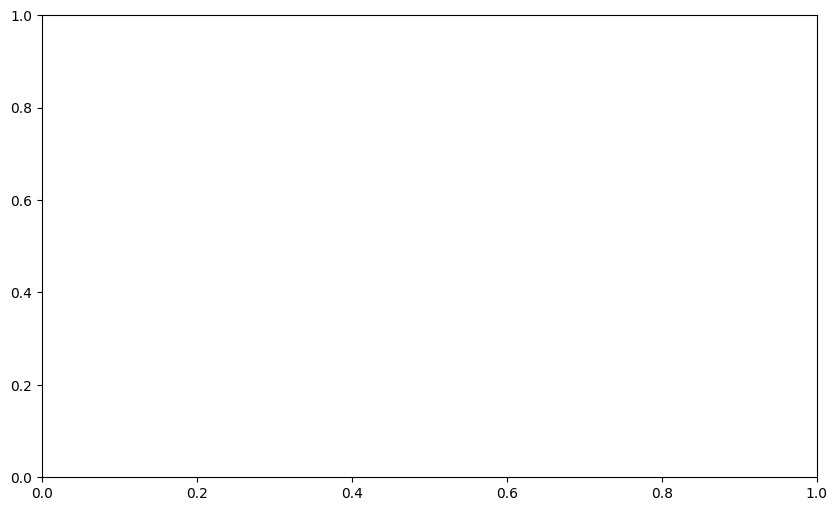

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 生成一个示例信号：1秒的正弦波
fs = 1024  # 采样频率
t = np.linspace(0, 1, fs)
signal = .5 * np.sin(2 * np.pi * 100 * t)  # 100Hz 正弦波

# 转换为 PyTorch 张量
signal_tensor = torch.tensor(signal, dtype=torch.float32)
print(signal_tensor)
# STFT 参数
n_fft = 256
hop_length = 128
win_length = 256
window = torch.hann_window(win_length)

# 计算 STFT
stft_result = torch.stft(signal_tensor, n_fft=n_fft, hop_length=hop_length,
                         win_length=win_length, window=window, return_complex=True)

# 获取幅度谱
magnitude = torch.abs(stft_result)

# 绘制 STFT 幅度谱
plt.figure(figsize=(10, 6))
plt.imshow(magnitude.T.numpy(), aspect='auto', origin='lower', extent=[0, 1, 0, fs / 2])
plt.colorbar(label='Magnitude')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('STFT Magnitude Spectrum')
plt.show()

In [10]:
# -*- coding: utf-8 -*-
"""
Mahalanobis module
--------------------------
"""
import torch
import torch.nn as nn

class MahalanobisLayer(nn.Module):

    def __init__(self, dim, decay = 0.1):
        super(MahalanobisLayer, self).__init__()
        self.S = torch.eye(dim)
        self.S_inv = torch.eye(dim)
        self.decay = decay

    def forward(self, x, x_fit):
        """
        Calculates the squared Mahalanobis distance between x and x_fit
        """

        delta = x - x_fit
        m = torch.matmul(torch.matmul(delta, self.S_inv), delta.t())
        return torch.diag(m)

    def cov(self, x):
        x -= torch.mean(x, dim=0)
        return 1 / (x.size(0) - 1) * x.t().matmul(x)

    def update(self, X, X_fit):
        """更新过程会让S渐渐接近于样本X和参考点X_fit的差值(delta = X - X_fit)的协方差。
        """
        delta = X - X_fit
        self.S = (1 - self.decay) * self.S + self.decay * self.cov(delta)
        self.S_inv = torch.pinverse(self.S)

if __name__ == "__main__":

    from scipy.spatial import distance
    import numpy as np

    # Some example data for testing
    v  = torch.Tensor([[1, 0.5, 0.5], [0.5, 1, 0.5], [0.5, 0.5, 1]])
    iv = torch.inverse(v)
    X1 = torch.Tensor([[1, 0, 0], [0, 1, 0], [0, 2, 0]])
    X2 = torch.Tensor([[0, 1, 0], [0, 2, 0], [0, 2, 0]])

    # Squared Mahalanobis distance using scipy
    scipy_dist_list = [distance.mahalanobis(x1.numpy(), x2.numpy(), iv.numpy()) for x1, x2 in zip(X1, X2)]
    scipy_dist = np.array(scipy_dist_list)**2

    # Mahalanobis distance pytorch implementation
    mah_layer = MahalanobisLayer(3, decay=0.99)
    mah_layer.S_inv = iv

    pytorch_dist = mah_layer(X1, X2)

     # Check if almost equal
    np.testing.assert_almost_equal(scipy_dist, pytorch_dist.numpy())

    # Covariance method
    X = torch.rand(10, 3)
    np_cov_X = np.cov(X.numpy(), rowvar=False)
    pytorch_cov_X = mah_layer.cov(X)

    # Check if almost equal
    np.testing.assert_almost_equal(np_cov_X, pytorch_cov_X.numpy())

    # Update method
    X_fit = torch.rand(10, 3)
    delta = X - X_fit
    np_cov_delta = np.cov(delta.numpy(), rowvar=False)
    pytorch_cov_delta = mah_layer.cov(delta)
    np.testing.assert_almost_equal(np_cov_delta, pytorch_cov_delta.numpy())

    # Check if almost equal after enough updates
    for i in range(20):
        mah_layer.update(X, X_fit)
    np.testing.assert_almost_equal(np_cov_delta, mah_layer.S.numpy())

    # Test if numpy inverse and pytorch pseudo inverse are close
    np.testing.assert_almost_equal(np.linalg.inv(np_cov_delta), mah_layer.S_inv.numpy(), decimal=5)

In [ ]:
import torch

def mahalanobis_distance(X, centers):
    # 计算协方差矩阵 (features_dim, features_dim)
    # 使用样本 X 估计协方差矩阵并计算逆矩阵
    cov_matrix = torch.cov(X.T)  # 假设 X 沿第0维是样本数，第1维是特征数
    cov_inv = torch.linalg.inv(cov_matrix)  # 计算协方差矩阵的逆

    # 扩展 X 和 centers 的维度以便进行广播计算
    X_expanded = X.unsqueeze(1)  # (batch_size, 1, features_dim)
    centers_expanded = centers.unsqueeze(0)  # (1, num_class, features_dim)

    # 计算每个样本与每个中心之间的差
    diff = X_expanded - centers_expanded  # (batch_size, num_class, features_dim)

    # 计算马氏距离的平方
    # 距离公式：sqrt((x - c)^T * cov_inv * (x - c))
    # 这里计算平方距离以避免开根号的开销
    mahalanobis_squared = torch.einsum('bcd,de,bce->bc', diff, cov_inv, diff)

    # 返回距离 (batch_size, num_class)
    return torch.sqrt(mahalanobis_squared)

# 示例数据
batch_size, features_dim, num_class = 32, 128, 10
X = torch.randn(batch_size, features_dim)
centers = torch.randn(num_class, features_dim)

# 计算马氏距离
distances = mahalanobis_distance(X, centers)
print(distances.shape)  # 应该输出 (batch_size, num_class)
print(distances)


torch.Size([32, 10])
tensor([[       nan,        nan,        nan, 27409.7793,        nan,        nan,
                nan, 15270.6250,        nan,        nan],
        [       nan,        nan,        nan, 27409.7891,        nan,        nan,
                nan, 15270.6045,        nan,        nan],
        [       nan,        nan,        nan, 27409.7773,        nan,        nan,
                nan, 15270.5928,        nan,        nan],
        [       nan,        nan,        nan, 27409.8105,        nan,        nan,
                nan, 15270.6182,        nan,        nan],
        [       nan,        nan,        nan, 27409.7930,        nan,        nan,
                nan, 15270.6240,        nan,        nan],
        [       nan,        nan,        nan, 27409.7812,        nan,        nan,
                nan, 15270.5957,        nan,        nan],
        [       nan,        nan,        nan, 27409.7910,        nan,        nan,
                nan, 15270.6045,        nan,        nan],
      

In [4]:
import numpy as np

# 示例二维ndarray
arr = np.random.rand(5, 3)  # 创建一个5x3的二维数组

# Z-Score 标准化
arr_standardized = (arr - arr.mean(axis=0)) / arr.std(axis=0)

print(arr_standardized)

# 最小-最大归一化
arr_normalized = (arr - arr.min(axis=0)) / (arr.max(axis=0) - arr.min(axis=0))

print(arr_normalized)



def normalize_to_range(matrix: np.ndarray, a, b, axis=0):
    """
    将数据归一化到指定的范围 [a, b]
    """
    # 计算数据的最小值和最大值
    min_val = matrix.min(axis=0)
    max_val = matrix.max(axis=0)
    
    # 归一化公式
    return a + (matrix - min_val) * (b - a) / (max_val - min_val) 

# 示例数据
data = np.random.rand(3, 4)
print(data)

# 归一化到 [0, 1] 范围
normalized_data_0_1 = normalize_to_range(data, 0, 1)
print("归一化到 [0, 1]:", normalized_data_0_1)

# 归一化到 [-1, 1] 范围
normalized_data_minus1_1 = normalize_to_range(data, -1, 1)
print("归一化到 [-1, 1]:", normalized_data_minus1_1)

# 归一化到 [10, 20] 范围
normalized_data_10_20 = normalize_to_range(data, 10, 20)
print("归一化到 [10, 20]:", normalized_data_10_20)



[[-1.66752185 -1.34429169  0.73768066]
 [ 1.20680026  0.51541657  1.24121191]
 [ 0.0030893   0.62537553 -1.49405552]
 [-0.34489145 -1.01972802  0.28931678]
 [ 0.80252373  1.22322762 -0.77415383]]
[[0.         0.         0.81591151]
 [1.         0.72432104 1.        ]
 [0.58121918 0.76714797 0.        ]
 [0.46015386 0.12641138 0.65199193]
 [0.85934891 1.         0.26319243]]
[[0.77532853 0.45971716 0.20698515 0.73934547]
 [0.69050825 0.749755   0.17331201 0.47961225]
 [0.49453489 0.07784619 0.19549354 0.92409771]]
归一化到 [0, 1]: [[1.         0.5683375  1.         0.58434581]
 [0.69792663 1.         0.         0.        ]
 [0.         0.         0.65873067 1.        ]]
归一化到 [-1, 1]: [[ 1.          0.136675    1.          0.16869162]
 [ 0.39585325  1.         -1.         -1.        ]
 [-1.         -1.          0.31746134  1.        ]]
归一化到 [10, 20]: [[20.         15.683375   20.         15.8434581 ]
 [16.97926627 20.         10.         10.        ]
 [10.         10.         16.5873067  20.

In [7]:
import torch

# 示例数据
bs = 16  # batch size
original_dim = 3712  # 原始特征维度
target_dim = 128  # 降维后的目标维度
A = torch.rand(bs, original_dim)  # bs × 3712 输入矩阵

# SVD 分解
U, S, Vh = torch.linalg.svd(A, full_matrices=False)  # full_matrices=False 保持矩阵紧凑
print(U.shape, S.shape, Vh.shape)
print(S)

# 获取前 128 个右奇异向量
V_k = Vh[:target_dim, :]  # Shape: 128 × 3712
print(V_k.shape)

# 降维
A_lowdim = torch.matmul(A, V_k.T)  # Shape: bs × 128

print("降维后的矩阵形状:", A_lowdim.shape)


torch.Size([16, 16]) torch.Size([16]) torch.Size([16, 3712])
tensor([122.9405,  18.3659,  18.3183,  18.1921,  18.1441,  17.9775,  17.7609,
         17.6385,  17.5347,  17.4124,  17.2192,  17.1543,  17.0958,  17.0253,
         16.8236,  16.5582])
torch.Size([16, 3712])
降维后的矩阵形状: torch.Size([16, 16])
